In [24]:
# === 0) Setup & Load ===
from pathlib import Path
import pandas as pd
import numpy as np

RES_DIR = Path("../results"); RES_DIR.mkdir(exist_ok=True, parents=True)
FIG_DIR = RES_DIR / "figures"; FIG_DIR.mkdir(exist_ok=True, parents=True)
MODEL_DIR = RES_DIR / "models"; MODEL_DIR.mkdir(exist_ok=True, parents=True)

df = pd.read_parquet("../data_work/loans_fe.parquet")  # or the latest engineered file
TARGET = "target"
TIME_COL = "issue_q_start"


In [25]:
# === 1) Time-based Split (train: <= 2017-12-31, test: >= 2018-01-01) ===
split_date = pd.Timestamp("2017-12-31")
train_df = df[df[TIME_COL] <= split_date].copy()
test_df  = df[df[TIME_COL] >  split_date].copy()

X_train = train_df.drop(columns=[TARGET, TIME_COL])
y_train = train_df[TARGET].astype(int)
X_test  = test_df.drop(columns=[TARGET, TIME_COL])
y_test  = test_df[TARGET].astype(int)

print(X_train.shape, X_test.shape, y_train.mean(), y_test.mean())


(1764843, 31) (494110, 31) 0.14756893389383646 0.01791706300216551


In [26]:
# === 2) Preprocessor: scale only continuous numeric features; passthrough booleans ===
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# continuous numerics = numeric with >2 unique values
cont_cols = [c for c in X_train.columns if np.issubdtype(X_train[c].dtype, np.number) and X_train[c].nunique() > 2]
# booleans (True/False one-hots)
bool_cols = X_train.select_dtypes(include=["bool"]).columns.tolist()
# any leftover small-cardinality numeric dummies (0/1) if present
bin_num_cols = [c for c in X_train.columns if c not in cont_cols and c not in bool_cols]

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), cont_cols),
        ("bool", "passthrough", bool_cols + bin_num_cols),
    ],
    remainder="drop",
)
print(f"Scaling {len(cont_cols)} continuous features; passing through {len(bool_cols)+len(bin_num_cols)} binary features.")

Scaling 15 continuous features; passing through 16 binary features.


In [27]:
cont_cols

['loan_amnt',
 'int_rate',
 'dti',
 'fico',
 'emp_length',
 'GDPC1',
 'UNRATE',
 'CPIAUCSL',
 'FEDFUNDS',
 'log_annual_inc',
 'UNRATE_delta_qoq',
 'FEDFUNDS_delta_qoq',
 'GDPC1_delta_qoq',
 'inflation_qoq',
 'real_rate_qoq']

In [28]:
bool_cols

['grade_b',
 'grade_c',
 'grade_d',
 'grade_e',
 'grade_f',
 'home_ownership_mortgage',
 'home_ownership_own',
 'home_ownership_rent',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_home_improvement',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_other',
 'purpose_small_business']

In [29]:
bin_num_cols

['term_m']

In [30]:
# === 3) Train class-balanced Logistic Regression 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

logreg = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1, solver="lbfgs"))
])
logreg.fit(X_train, y_train)
proba_lr_train = logreg.predict_proba(X_train)[:,1]
proba_lr_test  = logreg.predict_proba(X_test)[:,1]
print(f"LogReg AUC — train: {roc_auc_score(y_train, proba_lr_train):.3f}  test: {roc_auc_score(y_test, proba_lr_test):.3f}")


LogReg AUC — train: 0.706  test: 0.742


In [ ]:
#  Tree model: XGBoost if available; else HistGradientBoostingClassifier
proba_xgb_train = proba_xgb_test = None
try:
    from xgboost import XGBClassifier
    pos = int((y_train==1).sum()); neg = int((y_train==0).sum())
    spw = max(1.0, neg / max(1, pos))
    xgb = Pipeline([
        ("pre", pre),
        ("clf", XGBClassifier(
            n_estimators=500, max_depth=4, learning_rate=0.07,
            subsample=0.9, colsample_bytree=0.9, min_child_weight=1.0,
            reg_lambda=1.0, objective="binary:logistic", eval_metric="auc",
            tree_method="hist", random_state=42, scale_pos_weight=spw
        ))
    ])
    xgb.fit(X_train, y_train)
    proba_xgb_train = xgb.predict_proba(X_train)[:,1]
    proba_xgb_test  = xgb.predict_proba(X_test)[:,1]
    print(f"XGB AUC — train: {roc_auc_score(y_train, proba_xgb_train):.3f}  test: {roc_auc_score(y_test, proba_xgb_test):.3f}")
except Exception as e:
    from sklearn.ensemble import HistGradientBoostingClassifier
    hgb = Pipeline([
        ("pre", pre),
        ("clf", HistGradientBoostingClassifier(max_depth=4, learning_rate=0.07, random_state=42))
    ])
    hgb.fit(X_train, y_train)
    # decision_function-like output → use predict_proba via calibration trick? Not needed; use decision_function_
    # HGB exposes predict_proba for binary in recent sklearn; fall back to decision_function if needed:
    try:
        proba_xgb_train = hgb.predict_proba(X_train)[:,1]
        proba_xgb_test  = hgb.predict_proba(X_test)[:,1]
    except Exception:
        from sklearn.utils._response import _sigmoid
        proba_xgb_train = _sigmoid(hgb.decision_function(X_train))
        proba_xgb_test  = _sigmoid(hgb.decision_function(X_test))
    print(f"HGB AUC — train: {roc_auc_score(y_train, proba_xgb_train):.3f}  test: {roc_auc_score(y_test, proba_xgb_test):.3f}")
    xgb = hgb  # alias for downstream naming


XGB AUC — train: 0.718  test: 0.679


In [32]:
# === 4) Threshold tuning (maximize F1; change goal to “recall” if needed)
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def threshold_search(y_true, y_proba, grid=np.linspace(0.05, 0.5, 20), goal="f1"):
    best_t, best = 0.5, -1
    recs = []
    for t in grid:
        yhat = (y_proba >= t).astype(int)
        p = precision_score(y_true, yhat, zero_division=0)
        r = recall_score(y_true, yhat, zero_division=0)
        f = f1_score(y_true, yhat, zero_division=0)
        score = {"f1": f, "recall": r, "precision": p}[goal]
        recs.append((t, p, r, f))
        if score > best:
            best, best_t = score, t
    return best_t, np.array(recs)

best_t_lr, recs_lr = threshold_search(y_test, proba_lr_test, goal="f1")
print(f"Best threshold (LogReg) for F1: {best_t_lr:.3f}")

best_t_xgb = None
if proba_xgb_test is not None:
    best_t_xgb, recs_xgb = threshold_search(y_test, proba_xgb_test, goal="f1")
    print(f"Best threshold (Tree) for F1: {best_t_xgb:.3f}")


Best threshold (LogReg) for F1: 0.405
Best threshold (Tree) for F1: 0.500


In [33]:
# === 5) Full evaluation (AUC, F1, Precision, Recall, Accuracy) + figures ===

import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, precision_score, recall_score,
    RocCurveDisplay, PrecisionRecallDisplay, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import csv

metrics = []


In [34]:
# Logistic
yhat_lr = (proba_lr_test >= best_t_lr).astype(int)
metrics.append({
    "model": "logistic_balanced",
    "auc": roc_auc_score(y_test, proba_lr_test),
    "f1": f1_score(y_test, yhat_lr, zero_division=0),
    "accuracy": accuracy_score(y_test, yhat_lr),
    "precision": precision_score(y_test, yhat_lr, zero_division=0),
    "recall": recall_score(y_test, yhat_lr, zero_division=0),
    "ap": average_precision_score(y_test, proba_lr_test),
    "threshold": best_t_lr
})

In [35]:
metrics

[{'model': 'logistic_balanced',
  'auc': 0.7416747059087543,
  'f1': 0.10505310984220544,
  'accuracy': 0.9410009916820141,
  'precision': 0.07213018000927449,
  'recall': 0.19326781881847963,
  'ap': 0.050930068928154174,
  'threshold': np.float64(0.4052631578947368)}]

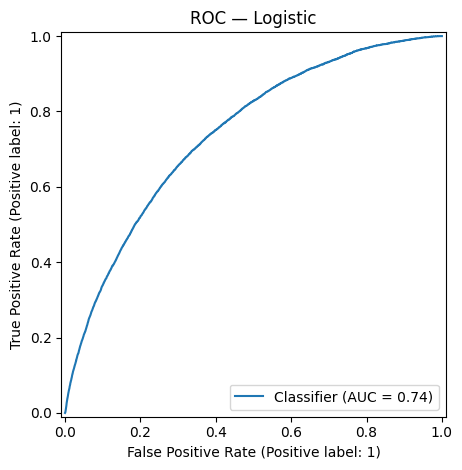

In [36]:
RocCurveDisplay.from_predictions(y_test, proba_lr_test)
plt.title("ROC — Logistic")
plt.tight_layout()
plt.savefig(FIG_DIR/"roc_logistic.png", dpi=300)
plt.show()

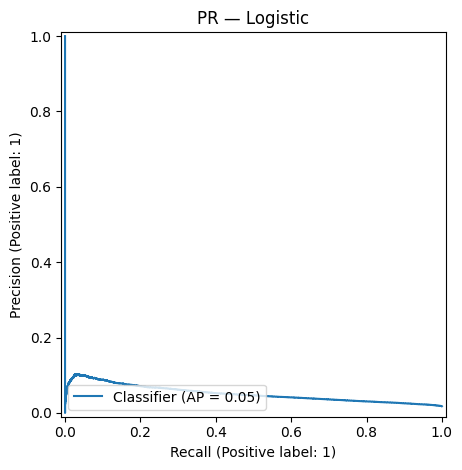

In [37]:
PrecisionRecallDisplay.from_predictions(y_test, proba_lr_test)
plt.title("PR — Logistic")
plt.tight_layout()
plt.savefig(FIG_DIR/"pr_logistic.png", dpi=300)
plt.show()


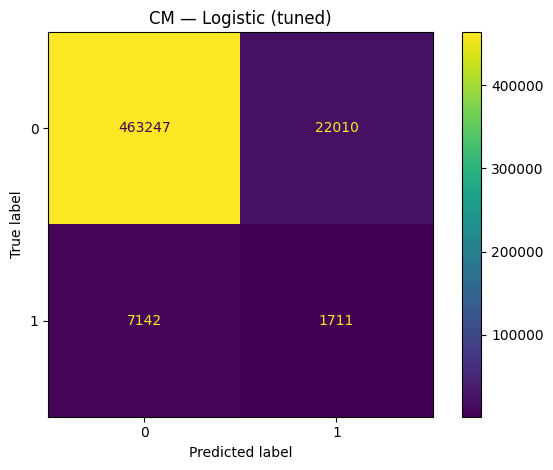

In [38]:
ConfusionMatrixDisplay(confusion_matrix(y_test, yhat_lr)).plot(values_format="d")
plt.title("CM — Logistic (tuned)")
plt.tight_layout()
plt.savefig(FIG_DIR/"cm_logistic.png", dpi=300)
plt.show()


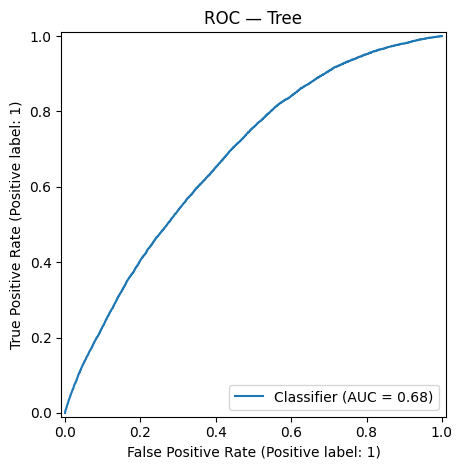

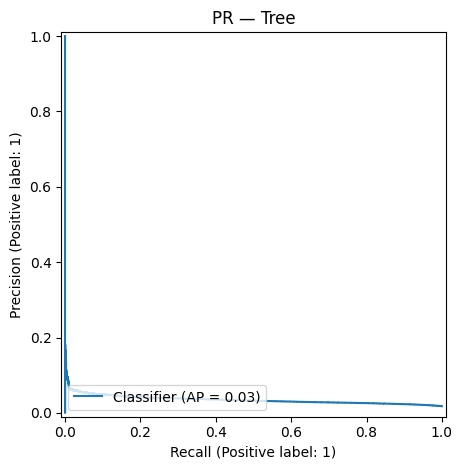

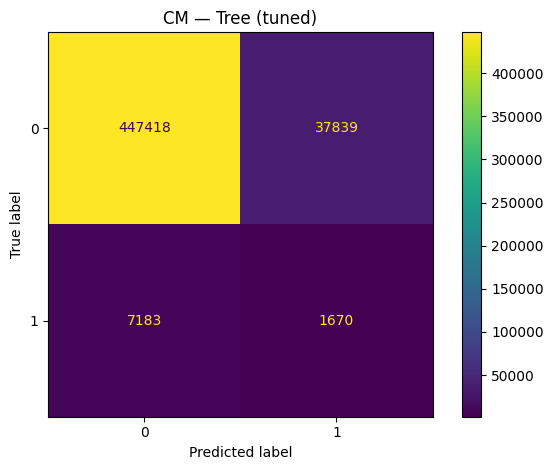

In [39]:
# Tree model (XGB or HGB)
if proba_xgb_test is not None and best_t_xgb is not None:
    yhat_xgb = (proba_xgb_test >= best_t_xgb).astype(int)
    metrics.append({
        "model": "xgb_or_hgb_balanced",
        "auc": roc_auc_score(y_test, proba_xgb_test),
        "f1": f1_score(y_test, yhat_xgb, zero_division=0),
        "accuracy": accuracy_score(y_test, yhat_xgb),
        "precision": precision_score(y_test, yhat_xgb, zero_division=0),
        "recall": recall_score(y_test, yhat_xgb, zero_division=0),
        "ap": average_precision_score(y_test, proba_xgb_test),
        "threshold": best_t_xgb
    })
    RocCurveDisplay.from_predictions(y_test, proba_xgb_test); plt.title("ROC — Tree"); plt.tight_layout(); plt.savefig(FIG_DIR/"roc_tree.png", dpi=300); plt.show()
    PrecisionRecallDisplay.from_predictions(y_test, proba_xgb_test); plt.title("PR — Tree"); plt.tight_layout(); plt.savefig(FIG_DIR/"pr_tree.png", dpi=300); plt.show()
    ConfusionMatrixDisplay(confusion_matrix(y_test, yhat_xgb)).plot(values_format="d"); plt.title("CM — Tree (tuned)"); plt.tight_layout(); plt.savefig(FIG_DIR/"cm_tree.png", dpi=300); plt.show()

In [42]:
metrics

[{'model': 'logistic_balanced',
  'auc': 0.7416747059087543,
  'f1': 0.10505310984220544,
  'accuracy': 0.9410009916820141,
  'precision': 0.07213018000927449,
  'recall': 0.19326781881847963,
  'ap': 0.050930068928154174,
  'threshold': np.float64(0.4052631578947368)},
 {'model': 'xgb_or_hgb_balanced',
  'auc': 0.6793896667011681,
  'f1': 0.06906248707663042,
  'accuracy': 0.9088826374693894,
  'precision': 0.042268850135412185,
  'recall': 0.18863662035468204,
  'ap': 0.03499114042581632,
  'threshold': np.float64(0.5)}]

In [ ]:
# === 6) Save metrics===
metrics_path = RES_DIR / "model_metrics.csv"
write_header = not metrics_path.exists()
with metrics_path.open("a", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["model","auc","f1","accuracy","precision","recall","ap","threshold"])
    if write_header: writer.writeheader()
    for m in metrics: writer.writerow(m)
print("✅ Saved metrics →", metrics_path)
print("📈 Saved figures →", FIG_DIR)

✅ Saved metrics → ../results/model_metrics.csv
📈 Saved figures → ../results/figures


In [44]:
# === 7) Persist models (for stress testing phase)===
import joblib
joblib.dump(logreg, MODEL_DIR / "logistic_balanced.joblib")
if 'xgb' in locals() and xgb is not None:
    joblib.dump(xgb, MODEL_DIR / "tree_balanced.joblib")
print("Models saved to:", MODEL_DIR)


Models saved to: ../results/models


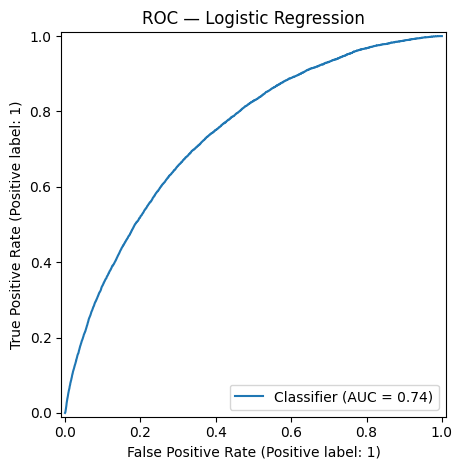

In [ ]:
# === 3) Logistic Regression pipeline, train, evaluate ===
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, RocCurveDisplay
import matplotlib.pyplot as plt
import csv

logreg = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", n_jobs=-1))
])

logreg_bal = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
        solver="lbfgs",
        penalty="l2",
        C=1.0
    ))
])

logreg.fit(X_train, y_train)
proba_lr = logreg.predict_proba(X_test)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int)

metrics = []
metrics.append({
    "model": "logistic_regression",
    "auc": roc_auc_score(y_test, proba_lr),
    "f1": f1_score(y_test, pred_lr),
    "accuracy": accuracy_score(y_test, pred_lr),
    "precision": precision_score(y_test, pred_lr, zero_division=0),
    "recall": recall_score(y_test, pred_lr, zero_division=0)
})

disp = RocCurveDisplay.from_predictions(y_test, proba_lr)
plt.title("ROC — Logistic Regression")
plt.tight_layout()
plt.savefig(FIG_DIR / "roc_logistic.png", dpi=300)
plt.show()


In [13]:
# ── Class weighting & refit (LogReg + XGB) ─────────────────────────────────────
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Logistic Regression with class_weight='balanced'
logreg_bal = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
        solver="lbfgs",
        penalty="l2",
        C=1.0
    ))
])
logreg_bal.fit(X_train, y_train)
proba_lr = logreg_bal.predict_proba(X_test)[:, 1]
auc_lr_train = roc_auc_score(y_train, logreg_bal.predict_proba(X_train)[:,1])
auc_lr_test  = roc_auc_score(y_test,  proba_lr)
print(f"LogReg (balanced) AUC — train: {auc_lr_train:.3f}  test: {auc_lr_test:.3f}")




LogReg (balanced) AUC — train: 0.706  test: 0.742


In [14]:
# XGBoost with scale_pos_weight (guarded)
try:
    from xgboost import XGBClassifier
    pos = (y_train==1).sum()
    neg = (y_train==0).sum()
    spw = max(1.0, neg / max(1, pos))  # class imbalance ratio

    xgb_bal = Pipeline([
        ("pre", pre),
        ("clf", XGBClassifier(
            n_estimators=500,
            max_depth=4,
            learning_rate=0.07,
            subsample=0.9,
            colsample_bytree=0.9,
            min_child_weight=1.0,
            reg_lambda=1.0,
            objective="binary:logistic",
            eval_metric="auc",
            tree_method="hist",
            random_state=42,
            scale_pos_weight=spw
        ))
    ])
    xgb_bal.fit(X_train, y_train)
    proba_xgb = xgb_bal.predict_proba(X_test)[:, 1]
    auc_xgb_train = roc_auc_score(y_train, xgb_bal.predict_proba(X_train)[:,1])
    auc_xgb_test  = roc_auc_score(y_test,  proba_xgb)
    print(f"XGB (balanced) AUC — train: {auc_xgb_train:.3f}  test: {auc_xgb_test:.3f}")

except Exception as e:
    xgb_bal = None
    proba_xgb = None
    print("XGBoost not available; continuing with Logistic only.", e)

XGB (balanced) AUC — train: 0.718  test: 0.679


In [15]:
# ── Threshold tuning helper ────────────────────────────────────────────────────
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def threshold_search(y_true, y_proba, grid=np.linspace(0.05, 0.5, 20), goal="f1"):
    best_t, best = 0.5, -1
    records = []
    for t in grid:
        y_hat = (y_proba >= t).astype(int)
        prec = precision_score(y_true, y_hat, zero_division=0)
        rec  = recall_score(y_true, y_hat, zero_division=0)
        f1   = f1_score(y_true, y_hat, zero_division=0)
        score = {"f1": f1, "recall": rec, "precision": prec}[goal]
        records.append((t, prec, rec, f1))
        if score > best:
            best, best_t = score, t
    return best_t, np.array(records)

# Logistic: choose threshold by F1 (you can switch to goal="recall")
best_t_lr, recs_lr = threshold_search(y_test, proba_lr, goal="f1")
print(f"Best threshold (LogReg) for F1: {best_t_lr:.3f}")

# XGB (if available)
if proba_xgb is not None:
    best_t_xgb, recs_xgb = threshold_search(y_test, proba_xgb, goal="f1")
    print(f"Best threshold (XGB) for F1: {best_t_xgb:.3f}")

Best threshold (LogReg) for F1: 0.405
Best threshold (XGB) for F1: 0.500


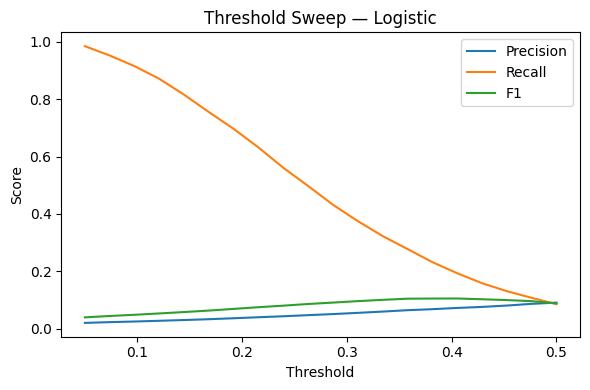

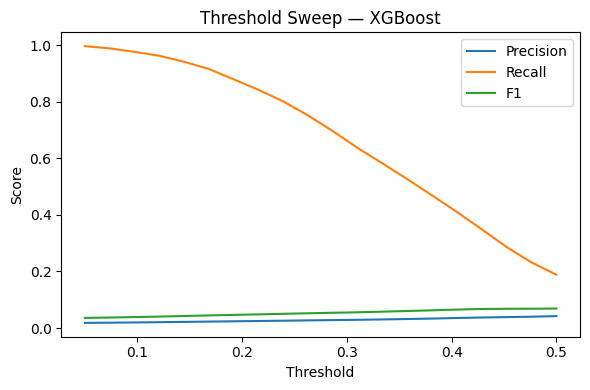

In [16]:
import matplotlib.pyplot as plt

def plot_threshold_curve(recs, title, fname):
    ts, prec, rec, f1 = recs[:,0], recs[:,1], recs[:,2], recs[:,3]
    plt.figure(figsize=(6,4))
    plt.plot(ts, prec, label="Precision")
    plt.plot(ts, rec,  label="Recall")
    plt.plot(ts, f1,   label="F1")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / fname, dpi=300)
    plt.show()

plot_threshold_curve(recs_lr, "Threshold Sweep — Logistic", "thresh_curve_logistic.png")
if proba_xgb is not None:
    plot_threshold_curve(recs_xgb, "Threshold Sweep — XGBoost", "thresh_curve_xgb.png")


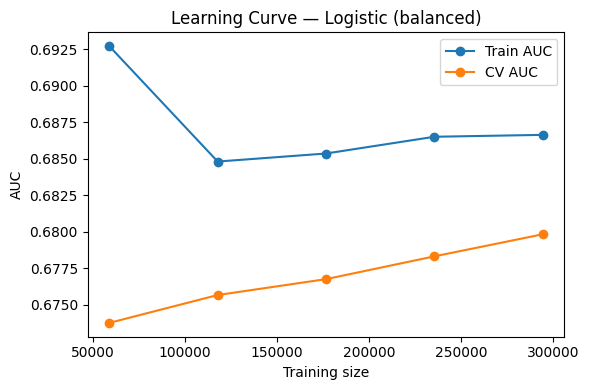

In [20]:
# ── Train vs Test AUC gap (already printed). Now learning curve for AUC ────────
from sklearn.model_selection import learning_curve, TimeSeriesSplit
from sklearn.metrics import make_scorer, roc_auc_score, get_scorer
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)  # respects temporal order on training data
auc_scorer = get_scorer("roc_auc")

train_sizes, train_scores, val_scores = learning_curve(
    estimator=logreg_bal,
    X=X_train, y=y_train,
    train_sizes=np.linspace(0.2, 1.0, 5),
    scoring=auc_scorer,
    cv=tscv,
    n_jobs=-1,
    shuffle=False
)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Train AUC")
plt.plot(train_sizes, val_scores.mean(axis=1),   marker="o", label="CV AUC")
plt.xlabel("Training size")
plt.ylabel("AUC")
plt.title("Learning Curve — Logistic (balanced)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "lc_logistic_auc.png", dpi=300)
plt.show()



/Users/binodtandan/UNT Research/ai_stress_testing/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/binodtandan/UNT Research/ai_stress_testing/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/binodtandan/UNT Research/ai_stress_testing/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/binodtandan/UNT Research/ai_stress_testing/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
 

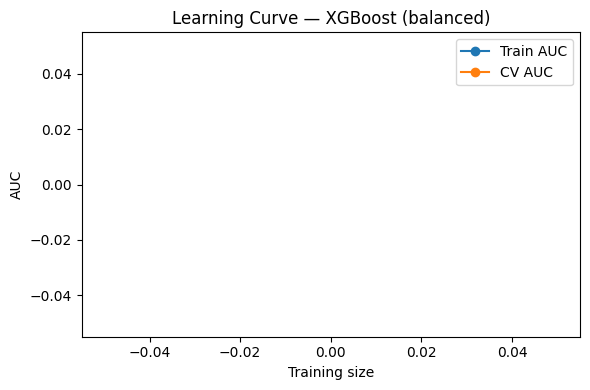

In [21]:
if xgb_bal is not None:
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=xgb_bal,
        X=X_train, y=y_train,
        train_sizes=np.linspace(0.2, 1.0, 5),
        scoring=auc_scorer,
        cv=tscv,
        n_jobs=-1,
        shuffle=False
    )
    plt.figure(figsize=(6,4))
    plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Train AUC")
    plt.plot(train_sizes, val_scores.mean(axis=1),   marker="o", label="CV AUC")
    plt.xlabel("Training size")
    plt.ylabel("AUC")
    plt.title("Learning Curve — XGBoost (balanced)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / "lc_xgb_auc.png", dpi=300)
    plt.show()


In [22]:
# ── Time-series aware hyperparameter tuning ────────────────────────────────────
from sklearn.model_selection import GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)

# Logistic grid (keep class_weight balanced)
log_grid = {
    "clf__C": [0.25, 0.5, 1.0, 2.0, 4.0]
}
log_cv = GridSearchCV(
    estimator=Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1))]),
    param_grid=log_grid,
    scoring="roc_auc",
    cv=tscv,
    n_jobs=-1,
    verbose=1
)
log_cv.fit(X_train, y_train)
print("LogReg best params:", log_cv.best_params_, "CV AUC:", log_cv.best_score_)
best_lr = log_cv.best_estimator_
proba_lr = best_lr.predict_proba(X_test)[:,1]
print("LogReg tuned test AUC:", roc_auc_score(y_test, proba_lr))




Fitting 5 folds for each of 5 candidates, totalling 25 fits
LogReg best params: {'clf__C': 0.5} CV AUC: 0.6889360388259063
LogReg tuned test AUC: 0.7416989902384375


[LogReg] Test AUC=0.742  AP=0.051
[LogReg] Thr=0.405  F1=0.105  P=0.072  R=0.193  Acc=0.941


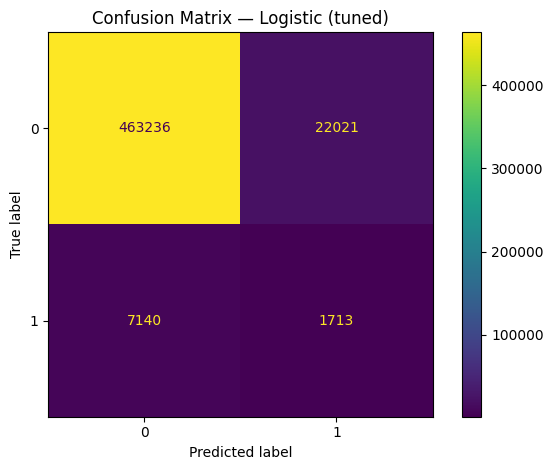

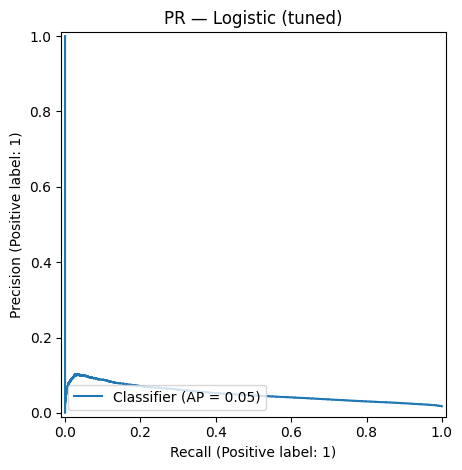

In [23]:
# ── Final metrics with tuned thresholds ────────────────────────────────────────
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score, confusion_matrix, ConfusionMatrixDisplay

# Logistic
best_t_lr, recs_lr = threshold_search(y_test, proba_lr, goal="f1")
yhat_lr = (proba_lr >= best_t_lr).astype(int)
print(f"[LogReg] Test AUC={roc_auc_score(y_test, proba_lr):.3f}  AP={average_precision_score(y_test, proba_lr):.3f}")
print(f"[LogReg] Thr={best_t_lr:.3f}  F1={f1_score(y_test, yhat_lr):.3f}  P={precision_score(y_test, yhat_lr, zero_division=0):.3f}  R={recall_score(y_test, yhat_lr):.3f}  Acc={accuracy_score(y_test, yhat_lr):.3f}")
ConfusionMatrixDisplay(confusion_matrix(y_test, yhat_lr)).plot(values_format="d")
plt.title("Confusion Matrix — Logistic (tuned)")
plt.tight_layout(); plt.savefig(FIG_DIR/"cm_logistic_tuned.png", dpi=300); plt.show()
PrecisionRecallDisplay.from_predictions(y_test, proba_lr)
plt.title("PR — Logistic (tuned)"); plt.tight_layout(); plt.savefig(FIG_DIR/"pr_logistic_tuned.png", dpi=300); plt.show()




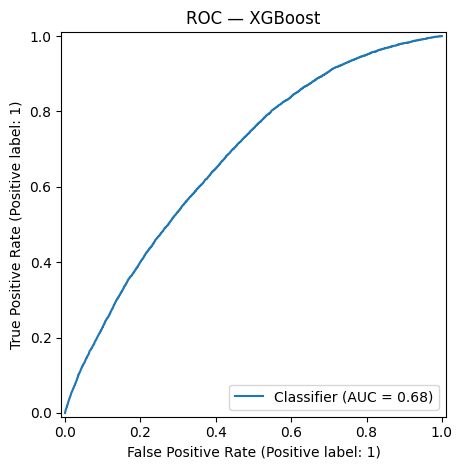

In [6]:
# === 4) XGBoost pipeline, train, evaluate (guarded if xgboost unavailable) ===
try:
    from xgboost import XGBClassifier

    pos = (y_train == 1).sum()
    neg = (y_train == 0).sum()
    spw = max(1.0, neg / max(1, pos))  # handle imbalance

    xgb = Pipeline([
        ("pre", pre),
        ("clf", XGBClassifier(
            n_estimators=400,
            max_depth=4,
            learning_rate=0.07,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            objective="binary:logistic",
            eval_metric="auc",
            tree_method="hist",
            random_state=42,
            scale_pos_weight=spw
        ))
    ])

    xgb.fit(X_train, y_train)
    proba_xgb = xgb.predict_proba(X_test)[:, 1]
    pred_xgb = (proba_xgb >= 0.5).astype(int)

    metrics.append({
        "model": "xgboost",
        "auc": roc_auc_score(y_test, proba_xgb),
        "f1": f1_score(y_test, pred_xgb),
        "accuracy": accuracy_score(y_test, pred_xgb),
        "precision": precision_score(y_test, pred_xgb, zero_division=0),
        "recall": recall_score(y_test, pred_xgb, zero_division=0)
    })

    disp = RocCurveDisplay.from_predictions(y_test, proba_xgb)
    plt.title("ROC — XGBoost")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "roc_xgb.png", dpi=300)
    plt.show()

except Exception as e:
    print("⚠️ XGBoost not available or failed to train:", e)


In [7]:
# === 5) Save metrics ===
metrics_path = RES_DIR / "model_metrics.csv"
write_header = not metrics_path.exists()

with metrics_path.open("a", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["model", "auc", "f1", "accuracy", "precision", "recall"])
    if write_header:
        writer.writeheader()
    for m in metrics:
        writer.writerow(m)

print("✅ Saved metrics →", metrics_path)
print("📈 ROC figures saved →", FIG_DIR)

✅ Saved metrics → ../results/model_metrics.csv
📈 ROC figures saved → ../results/figures


In [9]:
result = pd.DataFrame(metrics)

In [10]:
result

,model,auc,f1,accuracy,precision,recall
0,logistic_regression,0.741675,0.087953,0.968268,0.090669,0.085395
1,xgboost,0.677572,0.067944,0.909160,0.041624,0.184796


In [11]:
# === 6) Optional: quick feature importance exports ===
# Logistic: absolute coefficients (after preprocessing)
try:
    import numpy as np

    # get output feature names from ColumnTransformer
    def get_out_feature_names(ct, input_cols):
        names = []
        for name, trans, cols in ct.transformers_:
            if name == "remainder" and trans == "drop":
                continue
            if hasattr(trans, "get_feature_names_out"):
                base = trans.get_feature_names_out(cols)
                names.extend(base)
            else:
                # passthrough
                if isinstance(cols, slice):
                    names.extend(input_cols[cols])
                elif isinstance(cols, list):
                    names.extend(cols)
                else:
                    names.append(cols)
        return names

    out_names = get_out_feature_names(pre, X_train.columns)
    if "clf" in logreg.named_steps:
        coefs = logreg.named_steps["clf"].coef_.ravel()
        imp_lr = pd.DataFrame({"feature": out_names, "abs_coef": np.abs(coefs)}).sort_values("abs_coef", ascending=False)
        imp_lr.to_csv(RES_DIR / "importance_logistic.csv", index=False)
        print("📝 Saved logistic importances →", RES_DIR / "importance_logistic.csv")
except Exception as e:
    print("⚠️ Could not export logistic importances:", e)

# XGB: built-in importance
try:
    if "clf" in xgb.named_steps:
        booster = xgb.named_steps["clf"]
        # get feature names length match
        imp = pd.DataFrame({
            "feature": out_names,
            "gain": booster.get_booster().get_score(importance_type="gain")
        }).sort_values("gain", ascending=False)
        imp.to_csv(RES_DIR / "importance_xgb.csv", index=False)
        print("📝 Saved XGB importances →", RES_DIR / "importance_xgb.csv")
except Exception as e:
    print("⚠️ Could not export XGBoost importances:", e)


📝 Saved logistic importances → ../results/importance_logistic.csv
⚠️ Could not export XGBoost importances: Mixing dicts with non-Series may lead to ambiguous ordering.


In [13]:
print(imp_lr)

                       feature  abs_coef
6                       UNRATE  0.480749
16                     grade_c  0.425564
17                     grade_d  0.417216
29      purpose_small_business  0.373011
18                     grade_e  0.342656
7                     CPIAUCSL  0.327966
20     home_ownership_mortgage  0.291376
15                     grade_b  0.286688
8                     FEDFUNDS  0.262583
1                     int_rate  0.247381
14               real_rate_qoq  0.229612
19                     grade_f  0.227630
5                        GDPC1  0.214365
21          home_ownership_own  0.149766
3                         fico  0.138267
9               log_annual_inc  0.127469
27             purpose_medical  0.119299
0                    loan_amnt  0.098914
2                          dti  0.084108
25    purpose_home_improvement  0.074046
13               inflation_qoq  0.051097
23         purpose_credit_card  0.048095
26      purpose_major_purchase  0.039208
22         home_